# Simulate the observations
Run these in a handful of filters and with/without coronagraphy.

In [1]:
import json
import matplotlib.pyplot as plt
import copy
import numpy as np
import multiprocessing as mp
import pickle

from pandeia_funcs import *
import pandeia.engine
import pandeia_coronagraphy as pandeia_c

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# configure observations
template_dir = '/Users/grant/astro/code/github/pandeia-tutorials/configurations/jwst/miri/'
with open(template_dir+'imaging.json','r') as f:
    img_base = json.load(f)
    
# with open(template_dir+'coronography.json','r') as f:
#     cor_base = json.load(f)
cor_base = pandeia_c.engine.load_calculation( pandeia_c.engine.get_template('miri_coronagraphy_template.json') )

In [3]:
# lists of setups, change number of groups to limit imaging saturation,
# but avoid going below 5
# https://jwst-docs.stsci.edu/display/JPP/MIRI+Generic+Recommended+Strategies
subarrays  = ['mask1550', 'masklyot', 'sub256', 'sub256']
apertures  = ['fqpm1550', 'lyot2300', 'imager', 'imager']
filters    = ['f1550c',   'f2300c',   'f2100w', 'f2550w']
targ_ngrps = [ 100,        100,        7,        10]
ref_ngrps  = [ 100,        100,        5,        10]

# nint will be this/ngroups, 10,000 is approx 40-50 minutes
# for MIRI coron and sub256 subarrays
target_int = 10000
ref_int    = 10000

In [4]:
# get the scene
with open('targ.json','r') as f:
    targ_scene = json.load(f)
    
# add in a global offset to capture the effect of target acquisition error.
errx, erry = pandeia_c.scene.get_ta_error()
pandeia_c.scene.offset_scene(targ_scene,errx,erry)

# same for reference star
ref_scene = copy.deepcopy(targ_scene)
with open('ref.json','r') as f:
    ref_scene = json.load(f)
    
# And add target acquisition error
errx_ref, erry_ref = pandeia_c.scene.get_ta_error()
pandeia_c.scene.offset_scene(ref_scene,errx_ref,erry_ref)

In [5]:
# make a list, one element per observation
target = []
targ_star = []
ref_star = []
for suba, aper, filt, tngrp, rngrp in zip(subarrays, apertures, filters, targ_ngrps, ref_ngrps):

    if aper == 'imager':
        targ = copy.deepcopy(img_base)
        targ['configuration']['dynamic_image'] = True
        targ['configuration']['scene_size'] = 10.0
    else:
        targ = copy.deepcopy(cor_base)
        
    # target
    targ['configuration']['detector']['subarray'] = suba
    targ['configuration']['instrument']['aperture'] = aper
    targ['configuration']['instrument']['filter'] = filt
    targ['configuration']['detector']['ngroup'] = tngrp
    targ['configuration']['detector']['nint'] = target_int / tngrp
    targ['configuration']['detector']['readmode'] = 'fast'
    targ['scene'] = copy.deepcopy(targ_scene)

    # target star by itself
    star = copy.deepcopy(targ)
    star['scene'] = star['scene'][:1]
    
    # reference star
    ref = copy.deepcopy(targ)
    ref['configuration']['detector']['ngroup'] = rngrp
    ref['configuration']['detector']['nint'] = ref_int / rngrp
    ref['scene'] = copy.deepcopy(ref_scene)
    
    target.append(targ)
    targ_star.append(star)
    ref_star.append(ref)

In [6]:
# additional calculation config, if we're using pandeia_coronagraphy
pandeia_c.engine.options.wave_sampling = 10        # set ~10 for speed, >50 for accuracy
pandeia_c.engine.options.on_the_fly_PSFs = False   # True to get on-the-fly PSFs, only works for coron

In [7]:
# pandeia calculation, pandeia-coronagraphy package includes realistic noise 
# by not fixing a random seed
def calculate_batch(calcfiles, nprocesses=None):
    if nprocesses is None:
        nprocesses = mp.cpu_count()
    pool = mp.Pool(processes = nprocesses)
#     results = pool.map(pandeia.engine.perform_calculation.perform_calculation, calcfiles)
    results = pool.map(pandeia_c.engine.perform_calculation, calcfiles)
    pool.close()
    pool.join()
    return results

In [8]:
# do the calculation, gives quite a few warnings
results = calculate_batch(target+targ_star+ref_star)
target_results = results[:len(target)]
star_results = results[len(target):len(target)+len(targ_star)]
ref_results = results[len(target)+len(targ_star):]

/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
        Use astropy.modeling.blackbody.blackbody_nu instead. [astropy.utils.decorators]
        Use astropy.modeling.blackbody.blackbody_nu instead. [astropy.utils.decorators]
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-pac

In [9]:
# extract some relevant images
target_slope = []
target_snr = []
target_sat = []
star_slope = []
star_snr = []
star_sat = []
ref_slope = []
ref_snr = []
ref_sat = []
for t, s, r in zip(target_results, star_results, ref_results):
    target_slope.append(t['2d']['detector'])
    target_snr.append(t['2d']['snr'])
    target_sat.append(t['2d']['saturation'])
    star_slope.append(s['2d']['detector'])
    star_snr.append(s['2d']['snr'])
    star_sat.append(s['2d']['saturation'])
    ref_slope.append(r['2d']['detector'])
    ref_snr.append(r['2d']['snr'])
    ref_sat.append(r['2d']['saturation'])

# Explore the results
PSF is not properly generated for imaging.

pandeia_funcs.py:279: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im))


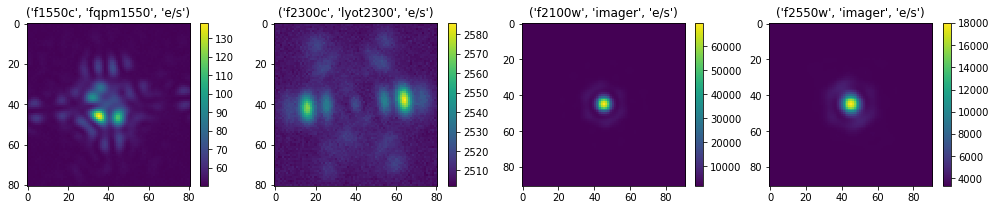

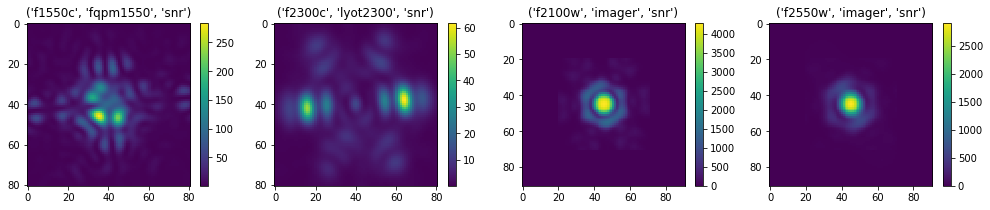

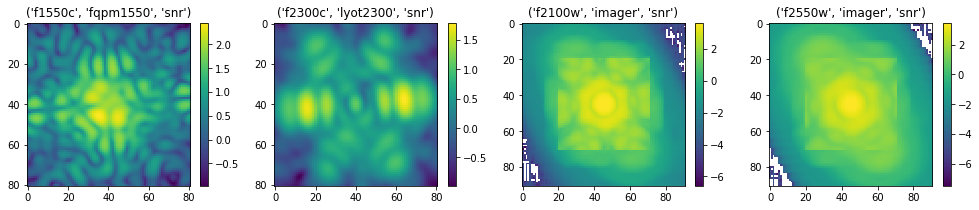

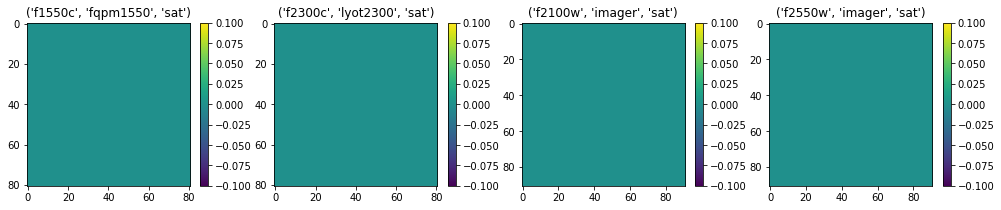

In [10]:
# target slope images
show_images(target_slope, title=zip(filters,apertures,np.tile('e/s',len(filters))))
show_images(target_snr, title=zip(filters,apertures,np.tile('snr',len(filters))), log=False)
show_images(target_snr, title=zip(filters,apertures,np.tile('snr',len(filters))), log=True)
show_images(target_sat, title=zip(filters,apertures,np.tile('sat',len(filters))))

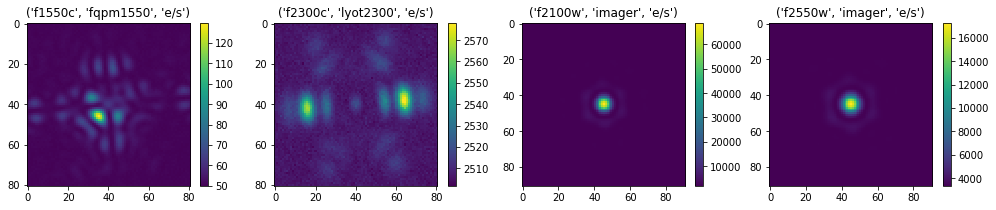

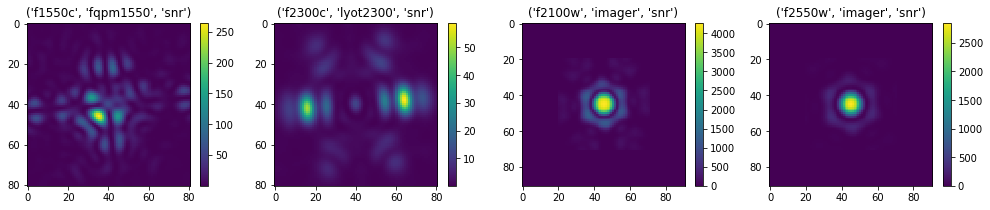

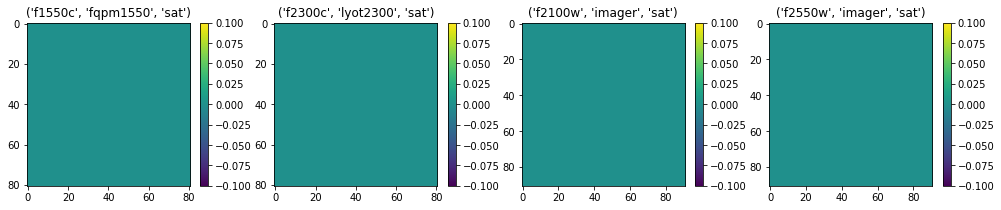

In [11]:
# star slope images
show_images(star_slope, title=zip(filters,apertures,np.tile('e/s',len(filters))))
show_images(star_snr, title=zip(filters,apertures,np.tile('snr',len(filters))))
show_images(star_sat, title=zip(filters,apertures,np.tile('sat',len(filters))))

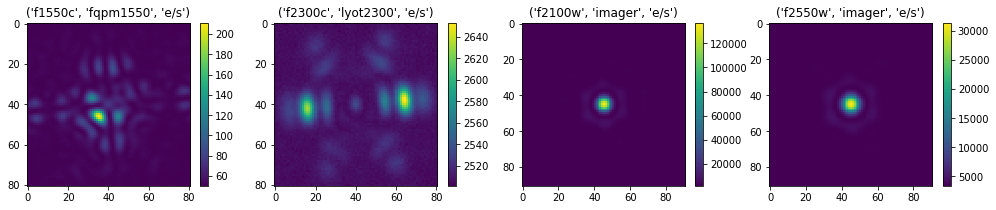

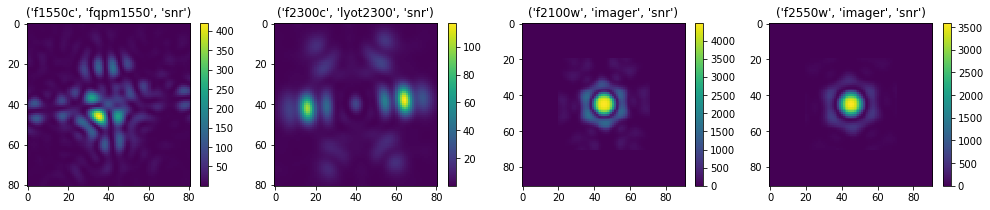

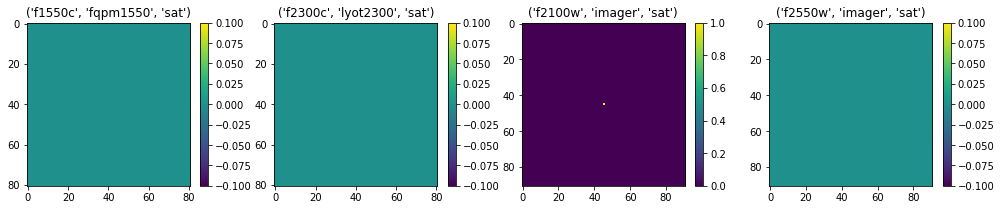

In [12]:
# reference slope images
show_images(ref_slope, title=zip(filters,apertures,np.tile('e/s',len(filters))))
show_images(ref_snr, title=zip(filters,apertures,np.tile('snr',len(filters))))
show_images(ref_sat, title=zip(filters,apertures,np.tile('sat',len(filters))))

pandeia_funcs.py:274: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im - sub[i]))


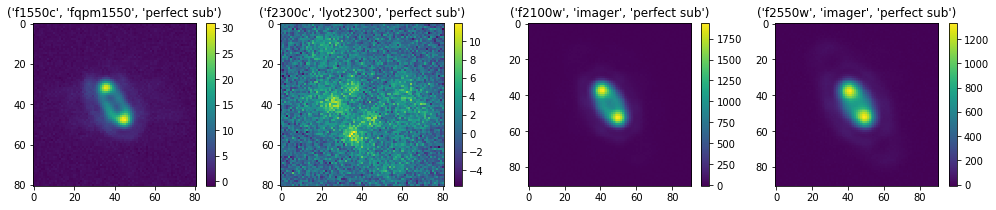

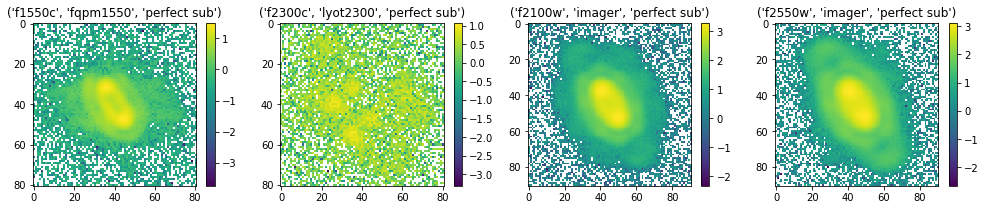

In [13]:
# subtraction in perfect case; reference is target star
show_images(target_slope, sub=star_slope, title=zip(filters,apertures,np.tile('perfect sub',len(filters))))
show_images(target_slope, sub=star_slope, title=zip(filters,apertures,np.tile('perfect sub',len(filters))), log=True)

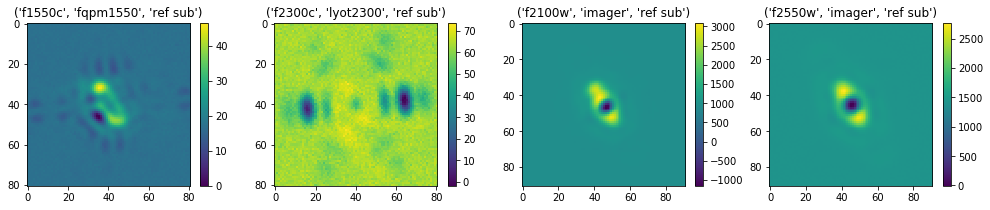

In [14]:
# reference subtraction without recentering
norm = [np.max(target_slope[i])/np.max(ref_slope[i]) for i in range(len(target_slope))]
sub = [r*n for r,n in zip(ref_slope, norm)]

show_images(target_slope, sub=sub, title=zip(filters,apertures,np.tile('ref sub',len(filters))))

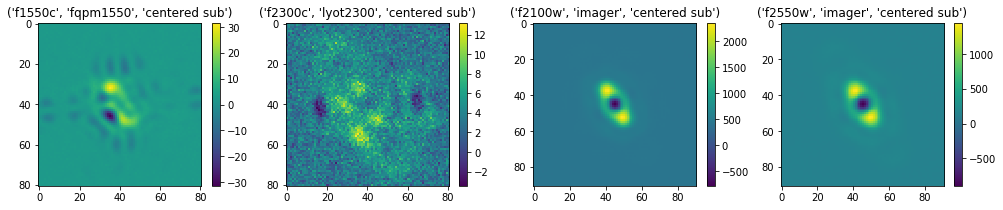

In [15]:
# registered subtraction
reg_ref = []
target_bg = []
for t,r in zip(target_slope, ref_slope):
    clean_ref = r.copy()
    clean_ref[np.isnan(r)] = np.nanmax(r)
    clean_ref -= np.percentile(clean_ref, 30)
    reg_ref.append(pandeia_c.analysis.register_to_target(clean_ref, t, rescale_reference=True))
    target_bg.append(t - np.percentile(t, 30))

show_images(target_bg, sub=reg_ref, title=zip(filters,apertures,np.tile('centered sub',len(filters))))

In [16]:
# save the results
with open('pandeia-results.pkl','wb') as f:
    pickle.dump(results, f)